In [1]:
import pandas as pd
import numpy as np
import scipy.io as sio
from scipy import signal
from scipy.integrate import simps
import matplotlib.pyplot as plt
import seaborn as sns


import dataloader as dl

## Load data

In [16]:
fileName = '110414'
EEG = sio.loadmat('./Data_Python/%s.mat'%(fileName))
data = EEG['data']
events = EEG['event']
chanlocs = EEG['chanlocs']
print('Shape of data ', data.shape)
print('Shape of events ', events.shape)
print('Shape of chanlocs ', chanlocs.shape)

Shape of data  (128, 596145)
Shape of events  (321, 2)
Shape of chanlocs  (1, 128)


In [17]:
# Extract channel label, theta, arc length
num_channel = chanlocs.shape[1]
chan_label, chan_theta, chan_arc_length = [], [], []

for i in range(num_channel):
    chan_label.append(chanlocs[0,i][0][0])
    chan_theta.append(chanlocs[0,i][1][0,0])
    chan_arc_length.append(chanlocs[0,i][2][0,0])
    
# create dataframe for them
d = {'label':chan_label, 'theta':chan_theta, 'arc_length':chan_arc_length}
channels = pd.DataFrame(data=d)

In [22]:
channels.to_csv('./Channel_coordinate/%s_channels.csv'%(fileName))

In [23]:
A = pd.read_csv('./Channel_coordinate/%s_channels.csv'%(fileName))

In [25]:
A = [1,3,5]

In [26]:
for i, a in enumerate(A):
    print(i)
    print(a)

0
1
1
3
2
5


In [29]:
events

array([[array([[0.5]]), array(['0'], dtype='<U1')],
       [array([[256]], dtype=uint16), array(['505'], dtype='<U3')],
       [array([[773.5]]), array(['3'], dtype='<U1')],
       [array([[2644.5]]), array(['501'], dtype='<U3')],
       [array([[2900]], dtype=uint16), array(['0'], dtype='<U1')],
       [array([[3027.5]]), array(['505'], dtype='<U3')],
       [array([[3542]], dtype=uint16), array(['1'], dtype='<U1')],
       [array([[6634.5]]), array(['501'], dtype='<U3')],
       [array([[6890]], dtype=uint16), array(['0'], dtype='<U1')],
       [array([[7017.5]]), array(['505'], dtype='<U3')],
       [array([[7531]], dtype=uint16), array(['2'], dtype='<U1')],
       [array([[8205.5]]), array(['501'], dtype='<U3')],
       [array([[8461]], dtype=uint16), array(['0'], dtype='<U1')],
       [array([[8588.5]]), array(['505'], dtype='<U3')],
       [array([[9103.5]]), array(['1'], dtype='<U1')],
       [array([[9764.5]]), array(['501'], dtype='<U3')],
       [array([[10020]], dtype=uint16

In [24]:
A

,Unnamed: 0,label,theta,arc_length
0,0,A1,-27.224712,0.469855
1,1,A2,-35.351458,0.481330
2,2,A3,-33.804159,0.524365
3,3,A4,-41.068033,0.374972
4,4,A5,-48.141936,0.416668
...,...,...,...,...
123,123,D28,151.815690,0.551752
124,124,D29,135.795161,0.572686
125,125,D30,-134.479988,0.519932
126,126,D31,-148.339104,0.571811


## Epoch data

In [4]:
sampling_rate = 256
num_epoch_1 = sum([1 if x[1]=='1' else 0 for x in events])
num_epoch_2 = sum([1 if x[1]=='2' else 0 for x in events])
num_epoch_3 = sum([1 if x[1]=='3' else 0 for x in events])
X1 = np.zeros((num_epoch_1, num_channel, sampling_rate*2))
Y1 = np.zeros(num_epoch_1)
X2 = np.zeros((num_epoch_2, num_channel, sampling_rate*2))
Y2 = np.zeros(num_epoch_2)
X3 = np.zeros((num_epoch_3, num_channel, sampling_rate*2))
Y3 = np.zeros(num_epoch_3)
print('Number of event 1: ', num_epoch_1)
print('Number of event 2: ', num_epoch_2)
print('Number of event 3: ', num_epoch_3)

Number of event 1:  20
Number of event 2:  33
Number of event 3:  12


In [11]:
iter_event = np.zeros(3).astype('int')
for i in range(events.shape[0]):
    event = events[i]
    event_time = int(event[0])
    event_type = event[1]
    
    # Event 1
    if event_type == '1':
        X1[iter_event[0],:,:] = data[:, event_time-2*sampling_rate:event_time]
        Y1[iter_event[0]] = int(events[i+1,0] - event_time)/sampling_rate
        iter_event[0] += 1
    # Event 2
    elif event_type == '2':
        X2[iter_event[1],:,:] = data[:, event_time-2*sampling_rate:event_time]
        Y2[iter_event[1]] = int(events[i+1,0] - event_time)/sampling_rate
        iter_event[1] += 1
    # Event 3
    elif event_type == '3':
        X3[iter_event[2],:,:] = data[:, event_time-2*sampling_rate:event_time]
        Y3[iter_event[2]] = int(events[i+1,0] - event_time)/sampling_rate
        iter_event[2] += 1
        
print('Shape of X1: ', X1.shape)
print('Shape of X2: ', X2.shape)
print('Shape of X3: ', X3.shape)

Shape of X1:  (20, 21, 512)
Shape of X2:  (33, 21, 512)
Shape of X3:  (12, 21, 512)


## Bandpower example (Separate)

In [2]:
X, Y = dl.read_data([1,2,3])

Event 1 X shape:  (324, 21, 512)
Event 2 X shape:  (546, 21, 512)
Event 3 X shape:  (226, 21, 512)
Combined X shape:  (1096, 21, 512)


(512,)
(65,)
(65,)


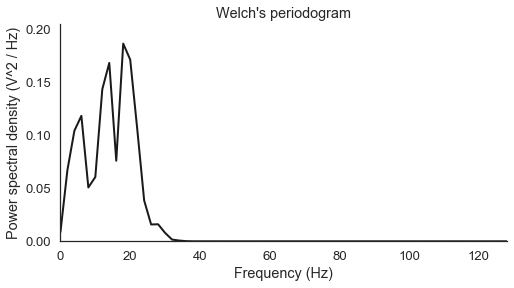

In [7]:
fs = 256
sample = X[525,12,:]
print(sample.shape)
# Define window length
win = 0.5*fs
freqs, psd = signal.welch(sample, fs, nperseg=win, noverlap=win/2)
print(freqs.shape)
print(psd.shape)

# Plot the power spectrum

sns.set(font_scale=1.2, style='white')
plt.figure(figsize=(8, 4))
plt.plot(freqs, psd, color='k', lw=2)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power spectral density (V^2 / Hz)')
plt.ylim([0, psd.max() * 1.1])
plt.title("Welch's periodogram")
plt.xlim([0, freqs.max()])
sns.despine()


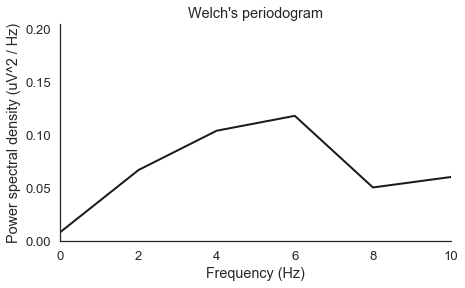

In [12]:
# Define lower and upper bounds
low, high = 13, 30

# Find intersecting values in frequency vector
idx_theta = np.logical_and(freqs >= low, freqs <= high)

# Plot the power spectral density and fill the delta area
plt.figure(figsize=(7, 4))
plt.plot(freqs, psd, lw=2, color='k')
plt.fill_between(freqs, psd, where=idx_theta, color='skyblue')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power spectral density (uV^2 / Hz)')
plt.xlim([0, 10])
plt.ylim([0, psd.max() * 1.1])
plt.title("Welch's periodogram")
sns.despine()

In [13]:
# Frequency resolution
freq_res = freqs[1] - freqs[0]  # = 1 / 4 = 0.25

# Compute the absolute power by approximating the area under the curve
delta_power = simps(psd[idx_theta], dx=freq_res)
print('Absolute delta power: %.3f uV^2' % delta_power)

Absolute delta power: 1.332 uV^2


## Calculate theta, alpha, beta bandpower (Together)

In [2]:
X, Y = dl.read_data([1,2,3])
fs = 256
# Define window length
win = 0.5*fs
freqs, psd = signal.welch(X, fs, nperseg=win, noverlap=win/2)
print(freqs.shape)
print(psd.shape)

Event 1 X shape:  (324, 21, 512)
Event 2 X shape:  (546, 21, 512)
Event 3 X shape:  (226, 21, 512)
Combined X shape:  (1096, 21, 512)
(65,)
(1096, 21, 65)


In [3]:
# Define lower and upper bounds
low, high = [4,7,13], [7,13,30]

# Find intersecting values in frequency vector
idx = np.logical_and(freqs[:,np.newaxis] >= low, freqs[:,np.newaxis] <= high)
idx = idx.T   # (65,3)->(3,65)

In [5]:
# Frequency resolution
freq_res = freqs[1] - freqs[0]  # = 1/0.5 = 2

# Compute the absolute power by approximating the area under the curve
powers = np.zeros((X.shape[0],X.shape[1],3))
for i in range(3):
    idx_power = idx[i,:]
    powers[:,:,i] = simps(psd[:,:,idx_power], dx=freq_res)

print(powers.shape)

(1096, 21, 3)


In [6]:
print('Absolute theta power: %.3f uV^2' % powers[525, 12, 0])
print('Absolute alpha power: %.3f uV^2' % powers[525, 12, 1])
print('Absolute beta power: %.3f uV^2' % powers[525, 12, 2])

Absolute theta power: 0.222 uV^2
Absolute alpha power: 0.291 uV^2
Absolute beta power: 1.332 uV^2


## Test Dataloder

In [5]:
import network_dataloader as ndl
import torch
from torchvision import models, transforms
import torch.utils.data as Data
import matplotlib.pyplot as plt

In [2]:
batchSize = 10
input_size = 224
# Load Data
data_transforms = {
        'train': transforms.Compose([
                ndl.Rescale(input_size),
                ndl.ToTensor()]), 
        'test': transforms.Compose([
                ndl.Rescale(input_size),
                ndl.ToTensor()])
        }

print("Initializing Datasets and Dataloaders...")

# Create training and testing datasets
image_datasets = {x: ndl.TopoplotLoader('images', x, data_transforms[x]) for x in ['train', 'test']}

# Create training and testing dataloaders
dataloaders_dict = {'train': Data.DataLoader(image_datasets['train'], batch_size=batchSize, shuffle=True, num_workers=4),
                    'test':  Data.DataLoader(image_datasets['test'], batch_size=batchSize, shuffle=False, num_workers=4)}

Initializing Datasets and Dataloaders...
> Found 58 images...
> Found 7 images...


In [3]:
for samples in dataloaders_dict['test']:
    print(samples['image'].shape)
    print(samples['label'])

torch.Size([7, 3, 224, 224])
tensor([ 26.4258,  23.5195,   7.3984,   9.4297,   5.9844, 170.8711,   4.7344])


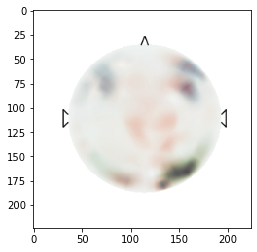

In [14]:
image = samples['image'][0].numpy().transpose((1,2,0))
plt.imshow(image)